# Simulation-based inference with ACE
## SIR task

To run this evaluation notebook, please move the notebook to the outside folder under `amortized-conditioning-engine/`, and please put your trained files under `results/sir` for standard task and `results/sir_pi` for ACE with prior injection.

In [1]:
import sys
import os

import hydra
import matplotlib.pyplot as plt
import torch
from torch.distributions import Uniform, Binomial, LogNormal
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_joint import Sampler
from src.dataset.sampler_twoway import Sampler as Sampler_base
from src.dataset.sbi.sir import SIR, SIROnline, SIROnlineAll, SIROnlineSamePrior

import pickle
import seaborn as sns
import sbi
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from sbi_demo_utils import *
from attrdict import AttrDict
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

update_plot_style()

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

/opt/miniconda3/envs/ace/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class SIR_npe(object):
    def __init__(self, total_count=1000, T=160):
        self.prior = [Uniform(0.01 * torch.ones(1), 1.5 * torch.ones(1)),
                     Uniform(0.02 * torch.ones(1), 0.25 * torch.ones(1))]
        self.total_count = total_count  # The maximum number of samples for binomial sampling
        self.T = T  # The total number of time steps

    def sample_theta(self, size):
        beta = self.prior[0].sample(size).reshape(-1, 1)
        gamma = self.prior[1].sample(size).reshape(-1, 1)
        
        return torch.cat([beta, gamma], dim=1)

    def __call__(self, thetas):
        beta = thetas[0]
        gamma = thetas[1]
        S0, I0, R0 = 999999, 1, 0  # Initial conditions

        N_total = S0 + I0 + R0

        S = torch.zeros(self.T)
        I = torch.zeros(self.T)
        R = torch.zeros(self.T)

        S[0], I[0], R[0] = S0, I0, R0

        # Simulate the SIR model dynamics
        for t in range(1, self.T):
            new_infections = beta * S[t - 1] * I[t - 1] / N_total
            new_recoveries = gamma * I[t - 1]

            S[t] = S[t - 1] - new_infections
            I[t] = I[t - 1] + new_infections - new_recoveries
            R[t] = R[t - 1] + new_recoveries

        num_bins = max(1, self.T // 10 + 1)
        # Subsample the data, only keep a subset of the infection data
        I_subsampled = I[::num_bins]  # Subsampling every `num_bins` steps

        I_subsampled = torch.where(I_subsampled < 0, torch.zeros_like(I_subsampled), I_subsampled)
        I_subsampled = torch.where(torch.isnan(I_subsampled), torch.zeros_like(I_subsampled), I_subsampled)

        I_sampled = Binomial(self.total_count, I_subsampled / N_total).sample()

        X = I_sampled / 1000

        return X

In [5]:
path = "results/sir/"
cfg_twoway, model_twoway = load_config_and_model(path=path, ckpt_name="ckpt_1.tar")

In [8]:
batch_size = 20
dataset = SIR(x_file="data/x_sir_10000.pt",
              theta_file="data/theta_sir_10000.pt",
              order="fixed",
              batch_size=batch_size)

num_ctx_for_ppd = 5

# define sampler
sampler = Sampler_base(problem=dataset, 
                       batch_size=batch_size,
                       num_ctx=10,
                       num_latent=2, 
                       min_num_points=num_ctx_for_ppd, 
                       max_num_points=num_ctx_for_ppd+1,
                       n_total_points=12,
                       ctx_tar_sampler="predict_latents_fixed")

eval_set = sampler.sample()

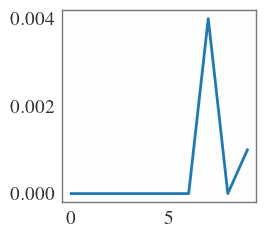

In [9]:
seed = 2
plt.plot(eval_set.xc[seed, :, 1], eval_set.yc[seed, :, 0] )
plt.show()

# Final evaluation

In [20]:
x_npe = torch.load("data/x_sir_10000.pt")
theta_npe = torch.load("data/theta_sir_10000.pt")

simulator = SIR_npe()
prior = simulator.prior
prior, *_ = process_prior(prior)

# train 5 NPE
posterior_npe = []
for seed in range(1):
    posterior_npe.append(train_npe(prior, theta_npe, x_npe))

# train 5 NRE
posterior_nre = []
for seed in range(5):
    posterior_nre.append(train_nre(prior, theta_npe, x_npe))

# save trained NPE and NRE
save_dir = "data/npe_posteriors_sir"
for i, posterior in enumerate(posterior_npe):
    save_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

save_dir = "data/nre_posteriors_sir"
for i, posterior in enumerate(posterior_nre):
    save_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

 Training neural network. Epochs trained: 101

In [3]:
# load trained NPE and NRE
save_dir = "data/npe_posteriors_sir"
posterior_npe = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_npe.append(pickle.load(handle))

save_dir = "data/nre_posteriors_sir"
posterior_nre = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_nre.append(pickle.load(handle))

## Evaluation of latents

In [13]:
n_runs = 5
batch_size = 100
dataset = SIROnlineAll(order="fixed")

num_ctx_for_ppd = 5

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=2, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

In [87]:
# save eval sets for posterior inference
data_dir = "data/eval_sets_sir"

torch.save(eval_set_oneway, os.path.join(data_dir, "eval_set_oneway.pt"))
torch.save(eval_set_twoway, os.path.join(data_dir, "eval_set_twoway.pt"))
torch.save(eval_set_pi_twoway_narrow, os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
torch.save(eval_set_pi_twoway_wide, os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [3]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_sir"

eval_set_oneway = torch.load(os.path.join(data_dir, "eval_set_oneway.pt"))
eval_set_twoway = torch.load(os.path.join(data_dir, "eval_set_twoway.pt"))
eval_set_pi_twoway_narrow = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
eval_set_pi_twoway_wide = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [6]:
n_runs = 5

# go first with NPE as it takes some time
all_log_probs_npe = np.zeros(5)
all_rmse_npe = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_npe = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_npe[i] = posterior_npe[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 10))
    all_log_probs_npe[seed] = log_probs_npe.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_npe_all = torch.empty([batch_size, 2, 200])
    for i in range(batch_size):
        samples_npe_all[i] = posterior_npe[seed].sample((200,), x=eval_set_oneway.yc[i].reshape(-1, 10), show_progress_bars=False).T
    all_rmse_npe[seed] = RMSE(eval_set_oneway.yt, samples_npe_all)

print(f"NPE Log probs mean: {all_log_probs_npe.mean().item()}")
print(f"NPE Log probs std: {all_log_probs_npe.std().item()}")

print(f"NPE RMSE mean: {all_rmse_npe.mean().item()}")
print(f"NPE RMSE std: {all_rmse_npe.std().item()}")

NPE Log probs mean: 6.52700834274292
NPE Log probs std: 0.10695321423647206
NPE RMSE mean: 0.023835419118404387
NPE RMSE std: 0.0005643740593904105


In [12]:
n_runs = 5

# go first with NRE as it takes some time
all_log_probs_nre = np.zeros(5)
all_rmse_nre = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_nre = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_nre[i] = posterior_nre[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 10))
    all_log_probs_nre[seed] = log_probs_nre.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_nre_all = torch.empty([batch_size, 2, 100])
    for i in range(batch_size):
        samples_nre_all[i] = posterior_nre[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 10), show_progress_bars=False).T
    all_rmse_nre[seed] = RMSE(eval_set_oneway.yt, samples_nre_all)

print(f"NRE Log probs mean: {all_log_probs_nre.mean().item()}")
print(f"NRE Log probs std: {all_log_probs_nre.std().item()}")

print(f"NRE RMSE mean: {all_rmse_nre.mean().item()}")
print(f"NRE RMSE std: {all_rmse_nre.std().item()}")

NRE Log probs mean: 6.2398193359375
NRE Log probs std: 0.1613214124891001
NRE RMSE mean: 0.030018803477287293
NRE RMSE std: 0.0030554746456341753


In [7]:
all_log_probs_ace = np.zeros(5)
all_log_probs_ace_pi_narrow = np.zeros(5)
all_log_probs_ace_pi_wide = np.zeros(5)

all_rmse_ace= np.zeros(5)
all_rmse_ace_pi_narrow = np.zeros(5)
all_rmse_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)
    
    
    # two way prior injection narrow
    path = "results/sir_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    log_probs_twoway_pi_narrow = -out_twoway_pi_narrow.losses.sum(dim=-1)
    all_log_probs_ace_pi_narrow[seed] = log_probs_twoway_pi_narrow.mean().detach().numpy()
    all_rmse_ace_pi_narrow[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_narrow)

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    log_probs_twoway_pi_wide = -out_twoway_pi_wide.losses.sum(dim=-1)
    all_log_probs_ace_pi_wide[seed] = log_probs_twoway_pi_wide.mean().detach().numpy()
    all_rmse_ace_pi_wide[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_wide)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

print(f"ACE PI wide Log probs mean: {all_log_probs_ace_pi_wide.mean().item()}")
print(f"ACE PI wide Log probs std: {all_log_probs_ace_pi_wide.std().item()}")
print(f"ACE PI wide RMSE mean: {all_rmse_ace_pi_wide.mean().item()}")
print(f"ACE PI wide RMSE std: {all_rmse_ace_pi_wide.std().item()}")

print(f"ACE PI narrow Log probs mean: {all_log_probs_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow Log probs std: {all_log_probs_ace_pi_narrow.std().item()}")
print(f"ACE PI narrow RMSE mean: {all_rmse_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow RMSE std: {all_rmse_ace_pi_narrow.std().item()}")

ACE Log probs mean: 6.77625732421875
ACE Log probs std: 0.015664397391029844
ACE RMSE mean: 0.020842582732439042
ACE RMSE std: 0.0002478945815978447
ACE PI wide Log probs mean: 6.615552234649658
ACE PI wide Log probs std: 0.09752091411045581
ACE PI wide RMSE mean: 0.020801429450511933
ACE PI wide RMSE std: 0.0006995676560891218
ACE PI narrow Log probs mean: 6.691895771026611
ACE PI narrow Log probs std: 0.10288250544332034
ACE PI narrow RMSE mean: 0.0189976092427969
ACE PI narrow RMSE std: 0.0007186853868303569


In [29]:
# Posterior MMD
all_mmd_ace = np.zeros(5)
all_mmd_ace_pi_narrow = np.zeros(5)
all_mmd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir/"
    config_path = path+".hydra/"
    cfg_twoway, model_twoway = load_config_and_model(path, config_path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_twoway[i].T, eval_set_twoway.yt[i].T, lengthscale=1))
    all_mmd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/sir_pi/"
    config_path = path+".hydra/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, config_path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_twoway_pi_narrow[i, :, :].T, eval_set_pi_twoway_narrow.yt[i, :, :].T, lengthscale=1))
    all_mmd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_twoway_pi_wide[i, :, :].T, eval_set_pi_twoway_wide.yt[i, :, :].T, lengthscale=1))
    all_mmd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 Posterior MMD mean: {all_mmd_ace.mean().item()}")
print(f"ACE-2 Posterior MMD std: {all_mmd_ace.std().item()}")

print(f"ACE-2 Posterior PI wide MMD mean: {all_mmd_ace_pi_wide.mean().item()}")
print(f"ACE-2 Posterior PI wide MMD std: {all_mmd_ace_pi_wide.std().item()}")

print(f"ACE-2 Posterior PI narrow MMD mean: {all_mmd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 Posterior PI narrow MMD std: {all_mmd_ace_pi_narrow.std().item()}")

ACE-2 Posterior MMD mean: 0.0007601579427719116
ACE-2 Posterior MMD std: 4.4334697331540154e-05
ACE-2 Posterior PI wide MMD mean: 0.0007104251384735106
ACE-2 Posterior PI wide MMD std: 3.051317440377449e-05
ACE-2 Posterior PI narrow MMD mean: 0.0005404678583145142
ACE-2 Posterior PI narrow MMD std: 2.7499087524391047e-05


In [4]:
n_runs=5

all_log_probs_ace = np.zeros(5)

all_rmse_ace= np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples.squeeze(-1)
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

ACE Log probs mean: 6.815367221832275
ACE Log probs std: 0.02252022626129036
ACE RMSE mean: 0.031530489772558214
ACE RMSE std: 0.00026844535387378875


## Evaluation of data

In [76]:
sampling_way = 3
eval_set_ppd, eval_set_ppd_pi_narrow, eval_set_ppd_pi_wide = sampler_joint.sample_ppd(sampling_way, know_theta=False)

In [80]:
# save eval sets for data prediction
data_dir = "data/eval_sets_ppd_sir"

torch.save(eval_set_ppd, os.path.join(data_dir, "eval_set_ppd.pt"))
torch.save(eval_set_ppd_pi_narrow, os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
torch.save(eval_set_ppd_pi_wide, os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [81]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_ppd_sir"

eval_set_ppd = torch.load(os.path.join(data_dir, "eval_set_ppd.pt"))
eval_set_ppd_pi_narrow = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
eval_set_ppd_pi_wide = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [77]:
all_mmd_ppd_ace = np.zeros(5)
all_mmd_ppd_ace_pi_narrow = np.zeros(5)
all_mmd_ppd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/sir_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway_pi_narrow = model_twoway_pi.forward(eval_set_ppd_pi_narrow, predict=True)
    samples_ppd_pi_twoway_narrow = out_ppd_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_narrow[i, :-2, :].T, eval_set_ppd_pi_narrow.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_ppd_twoway_pi_wide = model_twoway_pi.forward(eval_set_ppd_pi_wide, predict=True)
    samples_ppd_pi_twoway_wide = out_ppd_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_wide[i, :-2, :].T, eval_set_ppd_pi_wide.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

print(f"ACE-2 PPD PI wide MMD mean: {all_mmd_ppd_ace_pi_wide.mean().item()}")
print(f"ACE-2 PPD PI wide MMD std: {all_mmd_ppd_ace_pi_wide.std().item()}")

print(f"ACE-2 PPD PI narrow MMD mean: {all_mmd_ppd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 PPD PI narrow MMD std: {all_mmd_ppd_ace_pi_narrow.std().item()}")

ACE-2 PPD MMD mean: 0.021318742632865907
ACE-2 PPD MMD std: 0.0028651250991174643
ACE-2 PPD PI wide MMD mean: 0.01636168360710144
ACE-2 PPD PI wide MMD std: 0.0009707376087988935
ACE-2 PPD PI narrow MMD mean: 0.000187204360961914
ACE-2 PPD PI narrow MMD std: 2.1989640755374343e-05


In [33]:
all_mmd_ppd_ace = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir_gaussian_head/"
    config_path = path+".hydra/"
    cfg_twoway, model_twoway = load_config_and_model(path, config_path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples.squeeze(-1)
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

ACE-2 PPD MMD mean: 0.01847969151735306
ACE-2 PPD MMD std: 0.0012507516842166211


In [9]:
# Example data
model_A_data = all_rmse_ace
model_B_data = simformer_rmse

# Set parameters
n_data = len(model_A_data)  # Number of samples in the original data
n_bootstrap = int(1e5)  # Number of bootstrap resampling iterations
alpha = 0.05  # Significance level

# Calculate the median of the original data
mean_A = np.mean(model_A_data)
mean_B = np.mean(model_B_data)

print(f"Original mean of Model A: {mean_A}")
print(f"Original mean of Model B: {mean_B}")

# Initialize win counts
wins_A = 0
wins_B = 0

# Perform Bootstrap resampling
for _ in range(n_bootstrap):
    # Resample A with replacement and calculate the mean of the sampled data
    bootstrap_sample_A = np.random.choice(model_A_data, size=n_data, replace=True)
    mean_bootstrap_A = np.mean(bootstrap_sample_A)
    
    # Resample B with replacement and calculate the mean of the sampled data
    bootstrap_sample_B = np.random.choice(model_B_data, size=n_data, replace=True)
    mean_bootstrap_B = np.mean(bootstrap_sample_B)
    
    # Determine which model performs better and update win counts
    if mean_bootstrap_B < mean_bootstrap_A:
        wins_B += 1
    else:
        wins_A += 1

# Calculate the win percentage of Model B compared to Model A
win_percentage_B = wins_B / n_bootstrap

print(f"Win percentage of Model B: {win_percentage_B * 100:.2f}%")

# Determine statistical significance
if win_percentage_B < alpha:
    print("Model B is statistically significantly worse than Model A.")
else:
    print("There is no statistically significant difference between Model B and Model A")

Original mean of Model A: 0.020842582732439042
Original mean of Model B: 0.023600000000000003
Win percentage of Model B: 3.43%
Model B is statistically significantly worse than Model A.


In [83]:
torch.save(all_log_probs_npe, "results/metrics/sir_log_probs_npe.npy")
torch.save(all_log_probs_nre, "results/metrics/sir_log_probs_nre.npy")
torch.save(all_log_probs_ace, "results/metrics/sir_log_probs_ace.npy")
torch.save(all_log_probs_ace_pi_narrow, "results/metrics/sir_log_probs_ace_narrow.npy")
torch.save(all_log_probs_ace_pi_wide, "results/metrics/sir_log_probs_ace_wide.npy")

torch.save(all_rmse_npe, "results/metrics/sir_rmse_npe.npy")
torch.save(all_rmse_nre, "results/metrics/sir_rmse_nre.npy")
torch.save(all_rmse_ace, "results/metrics/sir_rmse_ace.npy")
torch.save(all_rmse_ace_pi_narrow, "results/metrics/sir_rmse_ace_narrow.npy")
torch.save(all_rmse_ace_pi_wide, "results/metrics/sir_rmse_ace_wide.npy")

torch.save(all_mmd_ppd_ace, "results/metrics/sir_mmd_ace.npy")
torch.save(all_mmd_ppd_ace_pi_narrow, "results/metrics/sir_mmd_ace_narrow.npy")
torch.save(all_mmd_ppd_ace_pi_wide, "results/metrics/sir_mmd_ace_wide.npy")

## Intro figure

In [14]:
sampling_way = 2

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

eval_set_ppd, eval_set_ppd_pi_narrow, eval_set_ppd_pi_wide = sampler_joint.sample_ppd(sampling_way, know_theta=False)


In [344]:
# import pickle
# with open('data/sir_eval_set_twoway.pkl', 'wb') as file:
#     pickle.dump(eval_set_twoway, file)

# with open('data/sir_eval_set_pi_twoway_narrow.pkl', 'wb') as file:
#     pickle.dump(eval_set_pi_twoway_narrow, file)

In [17]:
with open('data/sir_eval_set_twoway.pkl', 'rb') as file:
    eval_set_twoway = pickle.load(file)

with open('data/sir_eval_set_pi_twoway_narrow.pkl', 'rb') as file:
    eval_set_pi_twoway_narrow = pickle.load(file)

with open('data/sir_eval_set_twoway_ppd.pkl', 'rb') as file:
    eval_set_ppd = pickle.load(file)

with open('data/sir_eval_set_pi_twoway_ppd.pkl', 'rb') as file:
    eval_set_ppd_pi_narrow = pickle.load(file)



path = "results/sir/"
config_path = path+".hydra/"
cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{1}.tar")
out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
samples_twoway = out_twoway.samples

path = "results/sir_pi/"
config_path = path+".hydra/"
cfg_twoway_pi, model_pi_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{4}.tar")
out_twoway_pi_narrow = model_pi_twoway.forward(eval_set_pi_twoway_narrow, predict=True)
samples_twoway_pi_narrow = out_twoway_pi_narrow.samples

out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
samples_ppd_twoway = out_ppd_twoway.samples

out_ppd_pi_twoway = model_pi_twoway.forward(eval_set_ppd_pi_narrow, predict=True)
samples_ppd_pi_twoway = out_ppd_pi_twoway.samples

In [18]:
seed = 4

In [19]:
from torch.distributions import Uniform, Categorical, Normal
class PriorSampler:
    def __init__(self, num_bins, lower, upper):
        self.num_bins = num_bins
        self.bin_start = lower
        self.bin_end = upper

    def gaussian_to_binned_distribution(self, mean, std):
        """Convert a Gaussian distribution to a binned distribution"""
        linspace = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
        cdf_right = Normal(mean, std).cdf(linspace[1:])
        cdf_left = Normal(mean, std).cdf(linspace[:-1])
        bin_probs = cdf_right - cdf_left
        bin_probs /= bin_probs.sum()  # Normalize to ensure it's a valid probability distribution
        return bin_probs

    def sample_uniform_bin_weights(self):
        bin_probs = torch.ones(self.num_bins) / self.num_bins
        return bin_probs

    def sample_theta_from_bin_distribution(self, bin_weights, num_samples=1000):
        samples = []
        bin_edges = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
        for _ in range(num_samples):
            bins_indices = Categorical(bin_weights).sample().item()
            lower_edge = bin_edges[bins_indices]
            upper_edge = bin_edges[bins_indices + 1]
            theta = Uniform(lower_edge, upper_edge).sample()
            samples.append(theta.item())
        return samples


num_bins = 100

prior_sampler_beta = PriorSampler(num_bins, 0.01, 1.5)
prior_sampler_gamma = PriorSampler(num_bins, 0.02, 0.25)

bin_weights_beta = prior_sampler_beta.gaussian_to_binned_distribution(0.1, 0.3)
bin_weights_gamma = prior_sampler_gamma.gaussian_to_binned_distribution(0.13, 0.05)

samples_beta = prior_sampler_beta.sample_theta_from_bin_distribution(bin_weights_beta, num_samples=1000)
samples_gamma = prior_sampler_gamma.sample_theta_from_bin_distribution(bin_weights_gamma, num_samples=1000)


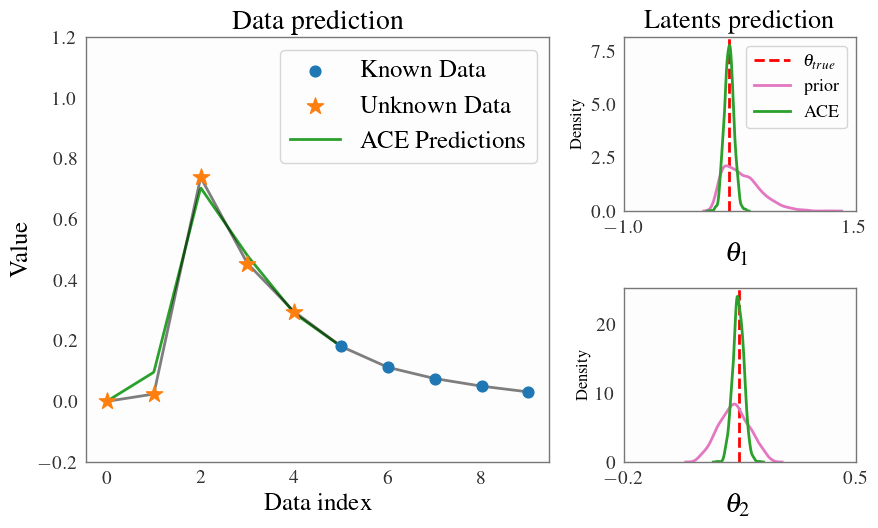

In [21]:
fig = plt.figure(figsize=(9, 5.5))
n_samples = 100


gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])

full_pred_samples = torch.cat([samples_ppd_pi_twoway[seed, :5, :n_samples], eval_set_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
xnew = np.linspace(0, 5, 300)
spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=1)
samples_smooth = spl(xnew)

true_data = torch.cat([eval_set_ppd.yt[seed, :5, 0], eval_set_ppd.yc[seed, :5, 0]])
ax1.plot(true_data, color='black', alpha=0.5, zorder=3)
ax1.scatter(eval_set_ppd.xc[seed, :5, 1], eval_set_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)
ax1.scatter(eval_set_ppd.xt[seed, :, 1], eval_set_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown Data', zorder=4, s=150)
ax1.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
# for i in range(n_samples):
#     ax1.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)
ax1.legend(fontsize=18, loc=1)
# ax1.grid(True)
ax1.set_ylim(-0.2, 1.2)
ax1.set_title("Data prediction", fontsize=20)
ax1.set_xlabel("Data index", fontsize=18)
ax1.set_ylabel("Value", fontsize=18)


ax2 = fig.add_subplot(gs[0, 1])
ax2.axvline(x=eval_set_twoway.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
sns.kdeplot(samples_beta, color="C6", linewidth=2, linestyle="solid", label="prior", ax=ax2)
sns.kdeplot(samples_twoway_pi_narrow[seed, 0, :], color="C2", linewidth=2, linestyle="solid", label="ACE", ax=ax2)
ax2.set_xlim(-1, 1.5)
ax2.set_xticks([-1,  1.5])
# ax2.set_yticks([])
ax2.set_title("Latents prediction", fontsize=19)
ax2.set_xlabel("$\\theta_1$", fontsize=20)
ax2.set_ylabel("Density", fontsize=12)
ax2.legend(fontsize=13, loc=1)


ax3 = fig.add_subplot(gs[1, 1])
ax3.axvline(x=eval_set_twoway.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
sns.kdeplot(samples_gamma, color="C6", linewidth=2, linestyle="solid", label="prior", ax=ax3)
sns.kdeplot(samples_twoway_pi_narrow[seed, 1, :], color="C2", linewidth=2, linestyle="solid", label="ACE-2", ax=ax3)

ax3.set_xlim(-0.2, 0.5)
ax3.set_xticks([-0.2,  0.5])
# ax3.set_yticks([])
ax3.set_xlabel("$\\theta_2$", fontsize=20)
ax3.set_ylabel("Density", fontsize=12)
# ax3.legend(fontsize=12, loc=0)

plt.tight_layout()

# tikzplotlib.save('figures/figure_1_e.tex', axis_width="\\figurewidth",
#                     axis_height="\\figureheight")

# plt.savefig("figures/figure_1e.png", dpi=300)
plt.show()


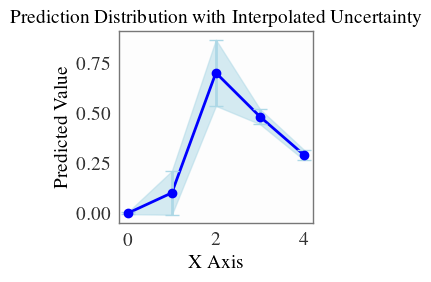

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

np.random.seed(42)
data = np.random.rand(5, 100)

means = np.mean(samples_ppd_pi_twoway[seed, :5, :].numpy(), axis=1)
stds = np.std(samples_ppd_pi_twoway[seed, :5, :].numpy(), axis=1)

x = np.array([0, 1, 2, 3, 4])

x_interp = np.linspace(x.min(), x.max(), 5) 
mean_interp_func = interp1d(x, means, kind='cubic') 
std_interp_func = interp1d(x, stds, kind='cubic') 

means_interp = mean_interp_func(x_interp)
stds_interp = std_interp_func(x_interp)

plt.plot(x_interp, means_interp, color='blue', linestyle='-', linewidth=2, label='Mean Prediction')

plt.fill_between(x_interp, means_interp - stds_interp, means_interp + stds_interp, color='lightblue', alpha=0.5, label='Uncertainty Region')

plt.errorbar(x, means, yerr=stds, fmt='o', color='blue', ecolor='lightblue', elinewidth=2, capsize=5, label='Prediction Points')

plt.xlabel('X Axis')
plt.ylabel('Predicted Value')
plt.title('Prediction Distribution with Interpolated Uncertainty')
# plt.legend()


plt.show()


In [616]:
torch.save(true_data, 'figure_1_sbi_true_data.pt')
torch.save(torch.tensor(samples_beta), 'figure_1_sbi_prior_samples.pt')
torch.save(torch.tensor(x_interp), 'figure_1_sbi_x_interp.pt')
torch.save(torch.tensor(means_interp), 'figure_1_sbi_mean_interp.pt')
torch.save(torch.tensor(stds_interp), 'figure_1_sbi_std_interp.pt')
torch.save(torch.tensor(samples_twoway_pi_narrow[seed, 0, :]), 'figure_1_sbi_posterior_samples.pt')

In [668]:
torch.save(means, 'figure_1_sbi_predict_mean.pt')
torch.save(stds, 'figure_1_sbi_predict_std.pt')

In [627]:
means = (samples_ppd_pi_twoway[seed, :5, :]).mean(1)
stds = (samples_ppd_pi_twoway[seed, :5, :]).std(1)

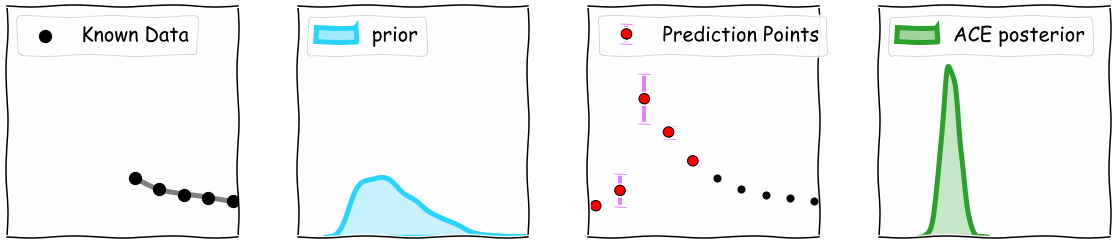

In [672]:
true_data = torch.load('figure_1_sbi_true_data.pt')
prior_samples = torch.load('figure_1_sbi_prior_samples.pt')
# x_interp = torch.load('figure_1_sbi_x_interp.pt')
# means_interp = torch.load('figure_1_sbi_mean_interp.pt')
stds_interp = torch.load('figure_1_sbi_std_interp.pt')
posterior_samples = torch.load('figure_1_sbi_posterior_samples.pt')

means = torch.load('figure_1_sbi_predict_mean.pt')
stds = torch.load('figure_1_sbi_predict_std.pt')

index = torch.arange(10)

plt.xkcd()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for ax in axs:
    ax.set_box_aspect(1)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_xlim(-0.2, 9.2)
axs[0].set_ylim(-0.2, 1.3)
axs[0].scatter(index[5:], true_data[5:], marker='o', color='black', label='Known Data', zorder=4, s=150)
axs[0].plot(index[5:], true_data[5:], color='black', alpha=0.5, zorder=3, linewidth=5)
axs[0].legend(fontsize=20, loc=2)


axs[1].set_xlim(-0.3, 1.1)
axs[1].set_ylim(0, 8)
sns.kdeplot(prior_samples, color="#2ad4ffc5", linewidth=5, linestyle="solid", fill=True, label="prior", ax=axs[1])
axs[1].legend(fontsize=20, loc=2)

axs[2].set_xlim(-0.3, 9.2)
axs[2].set_ylim(-0.2, 1.3)
axs[2].scatter(index[5:], true_data[5:], marker='o', color='black', zorder=4, s=50)
# axs[2].plot(index[5:], true_data[5:], color='black', alpha=0.6, zorder=3, linewidth=5)
# axs[2].plot(index[:6], torch.cat([torch.tensor(means_interp), true_data[5].unsqueeze(0)]), color='#e580ffff', linestyle='-', linewidth=5)
# axs[2].fill_between(x_interp, means_interp - stds_interp, means_interp + stds_interp, color='#e580ffff', alpha=0.5)
axs[2].errorbar(index[:5], means, yerr=stds, fmt='o', color='black', ecolor='#e580ffff', markersize=10, markerfacecolor="red",elinewidth=4, capsize=6, label='Prediction Points')

axs[2].legend(fontsize=20, loc=2)

axs[3].set_xlim(-0.3, 1.1)
axs[3].set_ylim(0, 10)
sns.kdeplot(posterior_samples, color="C2", linewidth=5, linestyle="solid", fill=True, label="ACE posterior", ax=axs[3])
axs[3].legend(fontsize=20, loc=2)

plt.tight_layout()

plt.show()

In [579]:
# axs[2].plot(xnew, samples_smooth.mean(-1), color="#e580ffff", alpha=1.0, linewidth=5, label='ACE Predictions')
# axs[2].plot(eval_set_ppd.xt[seed, :5, 1], samples_ppd_pi_twoway[seed, :5, :1], color="C4", alpha=1.0, linewidth=5, label='ACE Predictions')
# axs[2].scatter(eval_set_ppd.xt[seed, :5, 1], samples_smooth.mean(-1)[[0, 60, 120, 180, 240]], s=300, marker="*", zorder=7, color='#aa00d4ff')
# axs[2].plot(torch.arange(10), torch.cat([samples_ppd_pi_twoway[seed, :5, :1].reshape(-1), eval_set_ppd.yc[seed, :5, 0]]))
arrow = FancyArrowPatch((0.48, 0.5), (0.515, 0.5), mutation_scale=40, color='black', arrowstyle='->', transform=fig.transFigure, linewidth=4)

torch.Size([6, 100])

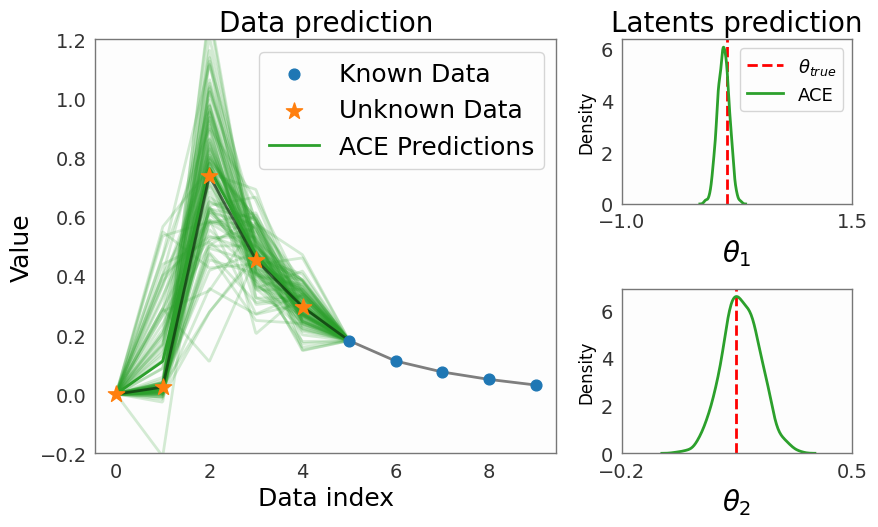

In [89]:
n_samples = 100

fig = plt.figure(figsize=(9, 5.5))
# plt.suptitle(f"SIR Posteriors and Data Prediction", size=20)

gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])

full_pred_samples = torch.cat([samples_ppd_twoway[seed, :, :n_samples], eval_set_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
xnew = np.linspace(0, 5, 300)
spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=1)
samples_smooth = spl(xnew)

true_data = torch.cat([eval_set_ppd.yt[seed, :5, 0], eval_set_ppd.yc[seed, :5, 0]])
ax1.plot(true_data, color='black', alpha=0.5, zorder=3)
ax1.scatter(eval_set_ppd.xc[seed, :5, 1], eval_set_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)
ax1.scatter(eval_set_ppd.xt[seed, :, 1], eval_set_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown Data', zorder=4, s=150)
ax1.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    ax1.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)
ax1.legend(fontsize=18, loc=1)
# ax1.grid(True)
ax1.set_ylim(-0.2, 1.2)
ax1.set_title("Data prediction", fontsize=20)
ax1.set_xlabel("Data index", fontsize=18)
ax1.set_ylabel("Value", fontsize=18)


ax2 = fig.add_subplot(gs[0, 1])
ax2.axvline(x=eval_set_twoway.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
sns.kdeplot(samples_twoway[seed, 0, :].detach().numpy(), color="C2", linewidth=2, linestyle="solid", label="ACE", ax=ax2)

ax2.set_xlim(-1, 1.5)
ax2.set_xticks([-1,  1.5])
ax2.set_title("Latents prediction", fontsize=20)
ax2.set_xlabel("$\\theta_1$", fontsize=20)
ax2.set_ylabel("Density", fontsize=12)
ax2.legend(fontsize=13, loc=1)


ax3 = fig.add_subplot(gs[1, 1])
ax3.axvline(x=eval_set_twoway.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

sns.kdeplot(samples_twoway[seed, 1, :].detach().numpy(), color="C2", linewidth=2, linestyle="solid", label="ACE-2", ax=ax3)

ax3.set_xlim(-0.2, 0.5)
ax3.set_xticks([-0.2,  0.5])
ax3.set_xlabel("$\\theta_2$", fontsize=20)
ax3.set_ylabel("Density", fontsize=12)
# ax3.legend(fontsize=12, loc=0)

plt.tight_layout()

# tikzplotlib.save('figures/figure_1_d.tex', axis_width="\\figurewidth",
#                     axis_height="\\figureheight")

plt.savefig("figures/figure_1d.png", dpi=300)
plt.show()


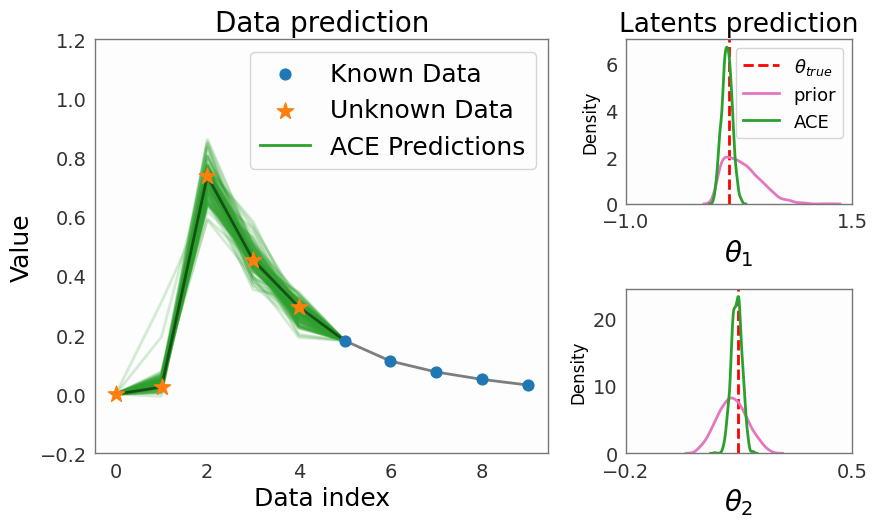

In [88]:
fig = plt.figure(figsize=(9, 5.5))
# plt.suptitle(f"SIR Posteriors and Data Prediction", size=20)


gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])

full_pred_samples = torch.cat([samples_ppd_pi_twoway[seed, :5, :n_samples], eval_set_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
xnew = np.linspace(0, 5, 300)
spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=1)
samples_smooth = spl(xnew)

true_data = torch.cat([eval_set_ppd.yt[seed, :5, 0], eval_set_ppd.yc[seed, :5, 0]])
ax1.plot(true_data, color='black', alpha=0.5, zorder=3)
ax1.scatter(eval_set_ppd.xc[seed, :5, 1], eval_set_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)
ax1.scatter(eval_set_ppd.xt[seed, :, 1], eval_set_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown Data', zorder=4, s=150)
ax1.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    ax1.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)
ax1.legend(fontsize=18, loc=1)
# ax1.grid(True)
ax1.set_ylim(-0.2, 1.2)
ax1.set_title("Data prediction", fontsize=20)
ax1.set_xlabel("Data index", fontsize=18)
ax1.set_ylabel("Value", fontsize=18)


ax2 = fig.add_subplot(gs[0, 1])
ax2.axvline(x=eval_set_twoway.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
sns.kdeplot(samples_beta, color="C6", linewidth=2, linestyle="solid", label="prior", ax=ax2)
sns.kdeplot(samples_twoway_pi_narrow[seed, 0, :], color="C2", linewidth=2, linestyle="solid", label="ACE", ax=ax2)
ax2.set_xlim(-1, 1.5)
ax2.set_xticks([-1,  1.5])
# ax2.set_yticks([])
ax2.set_title("Latents prediction", fontsize=19)
ax2.set_xlabel("$\\theta_1$", fontsize=20)
ax2.set_ylabel("Density", fontsize=12)
ax2.legend(fontsize=13, loc=1)


ax3 = fig.add_subplot(gs[1, 1])
ax3.axvline(x=eval_set_twoway.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
sns.kdeplot(samples_gamma, color="C6", linewidth=2, linestyle="solid", label="prior", ax=ax3)
sns.kdeplot(samples_twoway_pi_narrow[seed, 1, :], color="C2", linewidth=2, linestyle="solid", label="ACE-2", ax=ax3)

ax3.set_xlim(-0.2, 0.5)
ax3.set_xticks([-0.2,  0.5])
# ax3.set_yticks([])
ax3.set_xlabel("$\\theta_2$", fontsize=20)
ax3.set_ylabel("Density", fontsize=12)
# ax3.legend(fontsize=12, loc=0)

plt.tight_layout()

# tikzplotlib.save('figures/figure_1_e.tex', axis_width="\\figurewidth",
#                     axis_height="\\figureheight")

plt.savefig("figures/figure_1e.png", dpi=300)
plt.show()


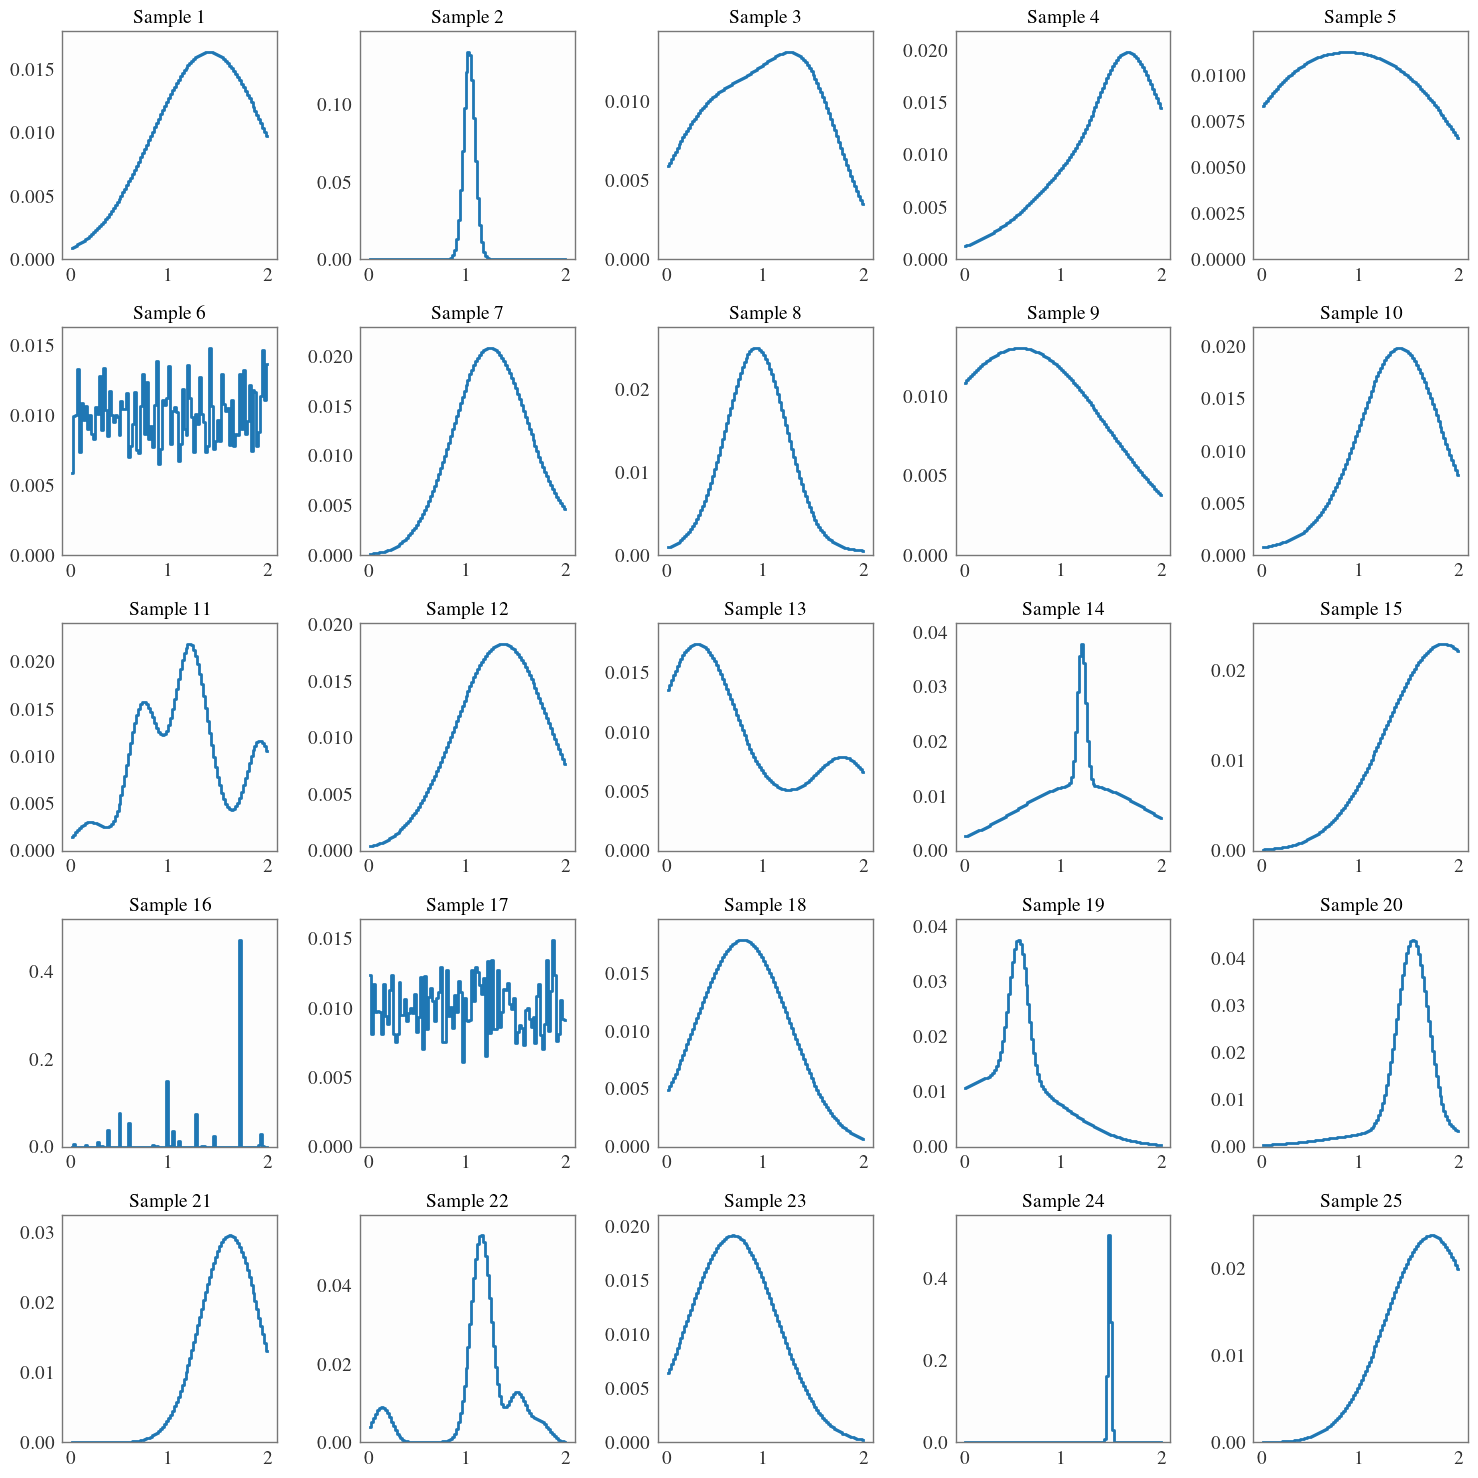

In [31]:
import torch
from torch.distributions import Normal, Geometric, Dirichlet, LogNormal, Categorical, Uniform
import matplotlib.pyplot as plt
import numpy as np

class Sampler:
    def __init__(self, num_bins, bin_start, bin_end):
        self.num_bins = num_bins
        self.bin_start = bin_start
        self.bin_end = bin_end
        self.mean_prior =  Uniform(torch.zeros(1), 2 * torch.ones(1))
        self.std_prior = Uniform(0.01 * torch.ones(1), 1 * torch.ones(1))
    
    def sample_mixture_gaussian_components(self):
        K = Geometric(0.4).sample().int().item() + 1
        component_type = Categorical(torch.tensor([1/3, 1/3, 1/3])).sample().item()
        
        means = self.mean_prior.sample((K,)).squeeze()
        stds = self.std_prior.sample((K,)).squeeze()

        if component_type == 0:
            means.fill_(self.mean_prior.sample().item())
        elif component_type == 1:
            stds.fill_(self.std_prior.sample().item())
        
        weights = Dirichlet(torch.ones(K)).sample()
        return means.reshape(-1), stds.reshape(-1), weights.reshape(-1)

    def sample_from_dirichlet(self):
        alpha0 = LogNormal(torch.log(torch.tensor(1.0)), 2).sample()
        bin_weights = Dirichlet(torch.full((self.num_bins,), alpha0)).sample()
        return bin_weights

    def sample_bin_weights(self):
        if torch.rand(1) < 0.8:
            means, stds, weights = self.sample_mixture_gaussian_components()
            bin_probs = torch.zeros(self.num_bins)
            linspace = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
            for mean, std, weight in zip(means, stds, weights):
                cdf_right = Normal(mean, std).cdf(linspace[1:])
                cdf_left = Normal(mean, std).cdf(linspace[:-1])
                bin_probs += weight * (cdf_right - cdf_left)
        else:
            bin_probs = self.sample_from_dirichlet()
        
        bin_probs /= bin_probs.sum()
        return bin_probs

    def sample_from_bin_distribution(self, bin_weights):
        bins_indices = Categorical(bin_weights).sample().item()
        bin_edges = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
        lower_edge = bin_edges[bins_indices]
        upper_edge = bin_edges[bins_indices + 1]
        random_value = Uniform(lower_edge, upper_edge).sample()
        return random_value, bins_indices


sampler = Sampler(num_bins=100, bin_start=0, bin_end=2)


fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        bin_weights = sampler.sample_bin_weights()
        random_value, selected_bin = sampler.sample_from_bin_distribution(bin_weights)
        
        bin_edges = np.linspace(sampler.bin_start, sampler.bin_end, sampler.num_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        axs[i, j].plot(bin_centers, bin_weights.numpy(), drawstyle='steps-mid')
        axs[i, j].set_title(f"Sample {i*5+j+1}")
        axs[i, j].set_ylim(0, max(bin_weights.numpy())*1.1)

plt.tight_layout()
plt.savefig("figures/sampled_prior.pdf")
plt.show()


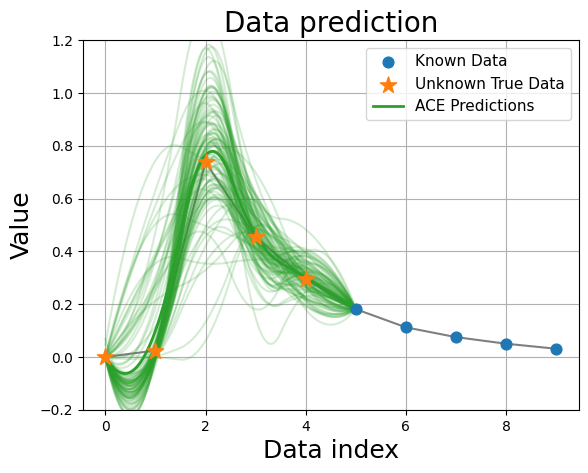

In [291]:
seed = 4
n_samples = 100


full_pred_samples = torch.cat([samples_ppd_twoway[seed, :, :n_samples], eval_set_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
xnew = np.linspace(0, 5, 300) 
spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=2)  # type: BSpline

samples_smooth = spl(xnew)

true_data = torch.cat([eval_set_twoway_ppd.yt[seed, :5, 0], eval_set_ppd.yc[seed, :5, 0]])
plt.plot(true_data, color='black', alpha=0.5, zorder=2)


plt.scatter(eval_set_ppd.xc[seed, :5, 1], eval_set_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)

plt.scatter(eval_set_ppd.xt[seed, :, 1], eval_set_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown True Data', zorder=4, s=150)

plt.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    plt.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)


plt.legend(fontsize=11, loc=1)

plt.grid(True)
plt.ylim(-0.2, 1.2)
plt.title("Data prediction", fontsize=20)
plt.xlabel("Data index", fontsize=18)
plt.ylabel("Value", fontsize=18)


plt.show()

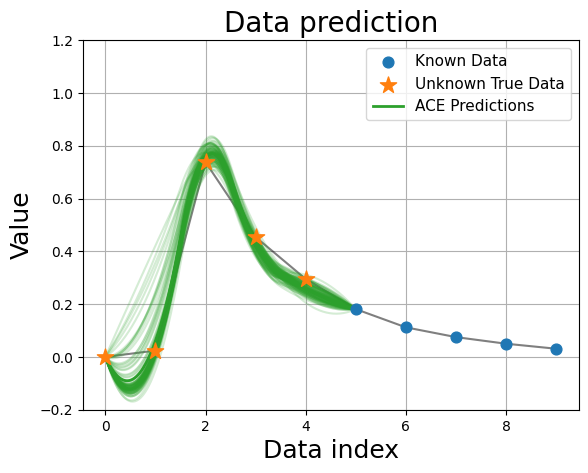

In [290]:
n_samples = 100

full_pred_samples = torch.cat([samples_ppd_pi_twoway[seed, :5, :n_samples], eval_set_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
xnew = np.linspace(0, 5, 300) 
spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=2)  # type: BSpline
samples_smooth = spl(xnew)

true_data = torch.cat([eval_set_ppd.yt[seed, :5, 0], eval_set_ppd.yc[seed, :5, 0]])
plt.plot(true_data, color='black', alpha=0.5, zorder=2)


plt.scatter(eval_set_ppd.xc[seed, :5, 1], eval_set_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)
plt.scatter(eval_set_ppd.xt[seed, :, 1], eval_set_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown True Data', zorder=4, s=150)

plt.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    plt.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)


plt.legend(fontsize=11, loc=1)

plt.grid(True)
plt.ylim(-0.2, 1.2)
plt.title("Data prediction", fontsize=20)
plt.xlabel("Data index", fontsize=18)
plt.ylabel("Value", fontsize=18)


plt.show()

# Plot on random data

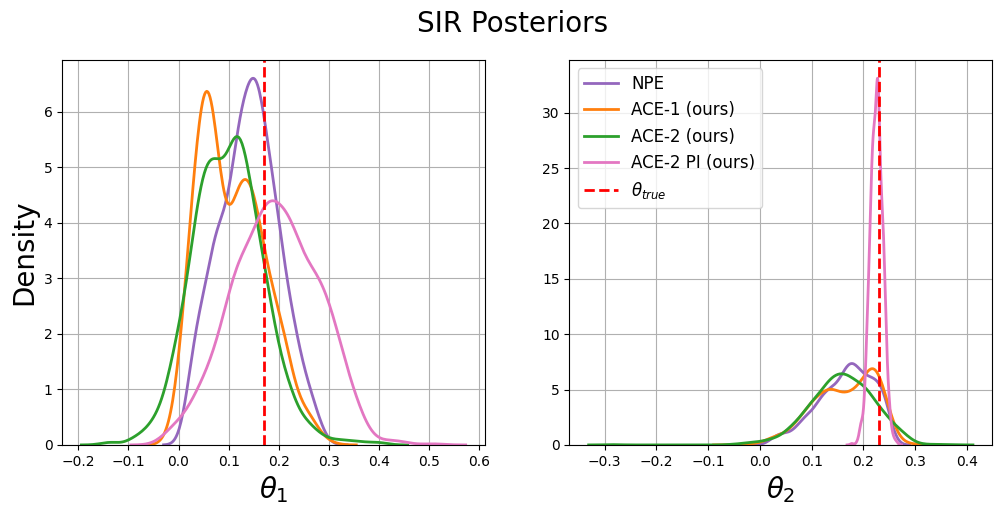

In [149]:
seed = 2

npe_samples = posterior.sample((1000,), x=eval_set_oneway.yc[seed].reshape(-1, 10), show_progress_bars=False)

plt.figure(figsize=[12,5])
plt.suptitle(f"SIR Posteriors", size=20)
plt.subplot(1, 2, 1)
sns.kdeplot(npe_samples[:, 0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
sns.kdeplot(samples_oneway[seed, 0, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE-1 (ours)")
sns.kdeplot(samples_twoway[seed, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
# sns.kdeplot(samples_pi_oneway[seed, 0, :], color = "C5", linewidth = 2, linestyle = "solid", label = "ACE-1 PI (ours)")
sns.kdeplot(samples_pi_twoway[seed, 0, :], color = "C6", linewidth = 2, linestyle = "solid", label = "ACE-2 PI (ours)")
plt.axvline(x=eval_set_oneway.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
sns.kdeplot(npe_samples[:, 1], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
sns.kdeplot(samples_oneway[seed, 1, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE-1 (ours)")
sns.kdeplot(samples_twoway[seed, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
# sns.kdeplot(samples_pi_oneway[seed, 1, :], color = "C5", linewidth = 2, linestyle = "solid", label = "ACE-1 PI (ours)")
sns.kdeplot(samples_pi_twoway[seed, 1, :], color = "C6", linewidth = 2, linestyle = "solid", label = "ACE-2 PI (ours)")
plt.axvline(x=eval_set_oneway.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(-2, 2)
plt.legend(fontsize=12, loc=0)
plt.xlabel("$\\theta_2$", fontsize = 20)
plt.ylabel(None)
plt.grid()
plt.show()

# Plot for observed data

In [37]:
# get the observed set
obs_set_oneway, obs_set_twoway, theta_true, x_obs = sampler_joint.get_obs()

out_obs_oneway = model_oneway.forward(obs_set_oneway,predict=True)
samples_obs_oneway = out_obs_oneway.samples

out_obs_twoway = model_twoway.forward(obs_set_twoway,predict=True)
samples_obs_twoway = out_obs_twoway.samples

In [38]:
log_probs_obs_npe = posterior.log_prob(theta=obs_set_oneway.yt[0].reshape(-1, 2), x=obs_set_oneway.yc[0].reshape(-1, 10))
print(f"NPE Log probs: {log_probs_obs_npe.item():.2f}")

log_probs_obs_oneway = out_obs_oneway.losses.sum(dim=-1)
print(f"ACE (one-way) Log probs: {log_probs_obs_oneway.item():.2f}")

log_probs_obs_twoway = out_obs_twoway.losses.sum(dim=-1)
print(f"ACE (two-way) Log probs: {log_probs_obs_twoway.item():.2f}")

NPE Log probs: 6.93
ACE (one-way) Log probs: 7.02
ACE (two-way) Log probs: 6.71


In [771]:
npe_samples_obs = posterior.sample((1000,), x=x_obs)

plt.figure(figsize=[12,5])
# plt.suptitle(f"SIR Posteriors (NPE:{log_probs_npe[seed]:.2f}; our: {log_probs_our[seed]:.2f})", size=20)
plt.subplot(1, 2, 1)

sns.kdeplot(npe_samples_obs[:, 0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
sns.kdeplot(samples_obs_oneway[0, 0, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE-1 (ours)")
sns.kdeplot(samples_obs_twoway[0, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=theta_true[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)


plt.subplot(1, 2, 2)
sns.kdeplot(npe_samples_obs[:, 1], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
sns.kdeplot(samples_obs_oneway[0, 1, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE-1 (ours)")
sns.kdeplot(samples_obs_twoway[0, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=theta_true[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(0, 0.8)
plt.legend(fontsize=18, loc=0)
plt.xlabel("$\\theta_2$", fontsize = 20)
plt.ylabel(None)
plt.show()

# Data prediction

In [150]:
batch_size = 20
dataset = SIR()

num_ctx_for_ppd = 5

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=2, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

In [168]:
mode = ['mixture', 'uniform', 'narrow_gaussian', 'narrow_uniform']
# get part data set for two-way sampler
sampling_way = 2
eval_set_twoway_ppd, eval_set_pi_twoway_ppd = sampler_joint.sample_ppd(sampling_way, know_theta=True, mode=mode[3], knowledge_degree=1.0)


In [74]:
# import pickle
# with open('data/sir_eval_set_twoway_ppd.pkl', 'wb') as file:
#     pickle.dump(eval_set_twoway_ppd, file)

# with open('data/sir_eval_set_pi_twoway_ppd.pkl', 'wb') as file:
#     pickle.dump(eval_set_pi_twoway_ppd, file)

In [180]:
with open('data/sir_eval_set_twoway_ppd.pkl', 'rb') as file:
    eval_set_twoway_ppd = pickle.load(file)

with open('data/sir_eval_set_pi_twoway_ppd.pkl', 'rb') as file:
    eval_set_pi_twoway_ppd = pickle.load(file)

In [185]:
out_ppd_twoway = model_twoway.forward(eval_set_twoway_ppd, predict=True)
samples_ppd_twoway = out_ppd_twoway.samples

out_ppd_pi_twoway = model_pi_twoway.forward(eval_set_pi_twoway_ppd, predict=True)
samples_ppd_pi_twoway = out_ppd_pi_twoway.samples

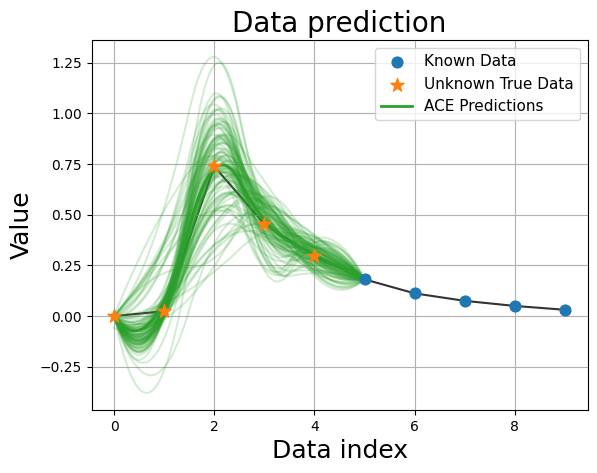

In [175]:
seed = 4
n_samples = 100

if sampling_way == 1:
    full_pred_samples = torch.cat([eval_set_twoway_ppd.yc[seed, 4:5].expand(-1, n_samples), samples_ppd_twoway[seed, :, :n_samples]], dim=0)
    xnew = np.linspace(4, 9, 300) 
    spl = make_interp_spline(np.arange(4, 10), full_pred_samples, k=2)  # type: BSpline
    # full_pred_samples = samples_ppd_twoway[seed, :, :n_samples]
    # xnew = np.linspace(5, 10, 300) 
    # spl = make_interp_spline(np.arange(5, 10), full_pred_samples, k=1)
    
    samples_smooth = spl(xnew)
    
    true_data = torch.cat([eval_set_twoway_ppd.yc[seed, :5, 0], eval_set_twoway_ppd.yt[seed, :5, 0]])

    # plt.plot(true_data[:5], color='C0', alpha=1, zorder=4, linewidth=2) # True known
    # plt.plot(np.arange(4, 10), true_data[4:], color='C1', alpha=1, zorder=4, linewidth=2)  # True unknown
    plt.plot(true_data, color='black', alpha=0.8, zorder=5)
elif sampling_way == 2:
    full_pred_samples = torch.cat([samples_ppd_twoway[seed, :, :n_samples], eval_set_twoway_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
    xnew = np.linspace(0, 5, 300) 
    spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=2)  # type: BSpline
    # full_pred_samples = samples_ppd_twoway[seed, :, :n_samples]
    # xnew = np.linspace(0, 4, 300) 
    # spl = make_interp_spline(np.arange(0, 5), full_pred_samples, k=2)
    
    samples_smooth = spl(xnew)

    true_data = torch.cat([eval_set_twoway_ppd.yt[seed, :5, 0], eval_set_twoway_ppd.yc[seed, :5, 0]])
    plt.plot(true_data, color='black', alpha=0.8, zorder=0)
    # plt.plot(true_data[:5], color='C1', alpha=1, zorder=4, linewidth=2) # True unknown
    # plt.plot(np.arange(5, 10), true_data[5:], color='C0', alpha=1, zorder=4, linewidth=2)


plt.scatter(eval_set_twoway_ppd.xc[seed, :5, 1], eval_set_twoway_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)

plt.scatter(eval_set_twoway_ppd.xt[seed, :, 1], eval_set_twoway_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown True Data', zorder=4, s=100)

plt.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    plt.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)
    # plt.scatter([eval_set_twoway_ppd.xt[seed, i, 1]] * n_samples, samples_ppd_twoway[seed, i, :n_samples], color='C2', alpha=0.5, label='Predictions' if i == 0 else "", zorder=3)
    # sns.violinplot(y=samples[seed, i, :n_samples], ax=plt.gca(), color="green", linewidth=2, alpha=0.7, labels=eval_set.xt[seed, i, 1])
# plt.plot(samples_ppd_twoway[seed, :], color='C2')

plt.legend(fontsize=11, loc=1)

plt.grid(True)
# plt.ylim(-0.1, 0.3)
plt.title("Data prediction", fontsize=20)
plt.xlabel("Data index", fontsize=18)
plt.ylabel("Value", fontsize=18)


plt.show()

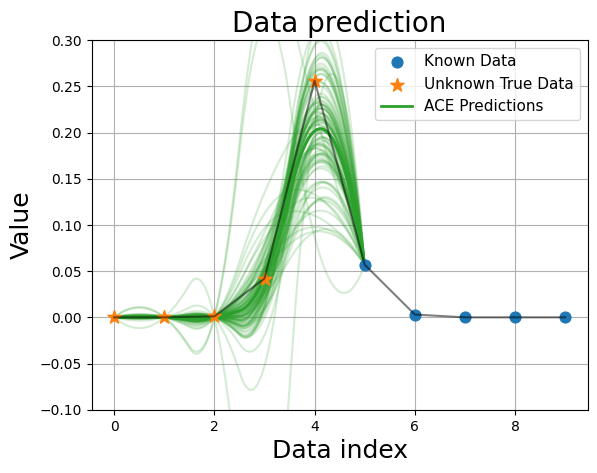

In [188]:
seed = 11
n_samples = 100

if sampling_way == 1:
    full_pred_samples = torch.cat([eval_set_twoway_ppd.yc[seed, 4:5].expand(-1, n_samples), samples_ppd_pi_twoway[seed, :5, :n_samples]], dim=0)
    xnew = np.linspace(4, 9, 300) 
    spl = make_interp_spline(np.arange(4, 10), full_pred_samples, k=2)  # type: BSpline
    # full_pred_samples = samples_ppd_pi_twoway[seed, :, :n_samples]
    # xnew = np.linspace(5, 10, 300) 
    # spl = make_interp_spline(np.arange(5, 10), full_pred_samples, k=1)
    
    samples_smooth = spl(xnew)
    
    true_data = torch.cat([eval_set_twoway_ppd.yc[seed, :5, 0], eval_set_twoway_ppd.yt[seed, :5, 0]])
    # plt.plot(true_data[:5], color='C0', alpha=1, zorder=4, linewidth=2) # True known
    # plt.plot(np.arange(4, 10), true_data[4:], color='C1', alpha=1, zorder=4, linewidth=2)  # True unknown
    plt.plot(true_data, color='black', alpha=0.8, zorder=0)
    
elif sampling_way == 2:
    full_pred_samples = torch.cat([samples_ppd_pi_twoway[seed, :5, :n_samples], eval_set_twoway_ppd.yc[seed, :1].expand(-1, n_samples)], dim=0)
    xnew = np.linspace(0, 5, 300) 
    spl = make_interp_spline(np.arange(0, 6), full_pred_samples, k=2)  # type: BSpline
    # full_pred_samples = samples_ppd_pi_twoway[seed, :5, :n_samples]
    # xnew = np.linspace(0, 4, 300) 
    # spl = make_interp_spline(np.arange(0, 5), full_pred_samples, k=2)
    
    samples_smooth = spl(xnew)

    true_data = torch.cat([eval_set_twoway_ppd.yt[seed, :5, 0], eval_set_twoway_ppd.yc[seed, :5, 0]])
    plt.plot(true_data, color='black', alpha=0.5, zorder=5)
    # plt.plot(true_data[:5], color='C0', alpha=1, zorder=4, linewidth=2)
    # plt.plot(np.arange(4, 10), true_data[4:], color='C1', alpha=1, zorder=4, linewidth=2)


plt.scatter(eval_set_twoway_ppd.xc[seed, :5, 1], eval_set_twoway_ppd.yc[seed, :5, 0], marker='o', color='C0', label='Known Data', zorder=4, s=60)

plt.scatter(eval_set_twoway_ppd.xt[seed, :, 1], eval_set_twoway_ppd.yt[seed, :, 0], marker='*', color='C1', label='Unknown True Data', zorder=4, s=100)

plt.plot(xnew, samples_smooth.mean(-1), color="C2", alpha=1.0, linewidth=2, label='ACE Predictions')
for i in range(n_samples):
    plt.plot(xnew, samples_smooth[:, i], color="C2", alpha=0.2)
    # plt.scatter([eval_set_twoway_ppd.xt[seed, i, 1]] * n_samples, samples_ppd_pi_twoway[seed, i, :n_samples], color='C2', alpha=0.5, label='Predictions' if i == 0 else "", zorder=3)
    # sns.violinplot(y=samples[seed, i, :n_samples], ax=plt.gca(), color="green", linewidth=2, alpha=0.7, labels=eval_set.xt[seed, i, 1])
# plt.plot(samples_ppd_pi_twoway[seed, :], color='C2')

plt.legend(fontsize=11, loc=1)

plt.grid(True)
plt.ylim(-0.1, 0.3)
plt.title("Data prediction", fontsize=20)
plt.xlabel("Data index", fontsize=18)
plt.ylabel("Value", fontsize=18)


plt.show()